In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.optim import SGD
import time
import os

In [12]:
#https://drive.google.com/drive/folders/1nfQZe8OYJNzGYfV8D3bprSzmFQoSkuaN?usp=drive_link
#directory = '/content/drive/MyDrive/DL/fish'
directory = 'data'

train_files = []
target_files = []
fish_types = 'Black Sea Sprat'
for file in os.listdir(os.path.join(directory, fish_types)):
    train_files.append(os.path.join(directory, 'Black Sea Sprat', file))
    target_files.append(os.path.join(directory,  'Black Sea Sprat GT', file))

len(train_files), len(target_files)

(1000, 1000)

In [13]:
df = pd.DataFrame({'img' : train_files, 'mask' : target_files})
df.head()

,img,mask
0,data\Black Sea Sprat\00001.png,data\Black Sea Sprat GT\00001.png
1,data\Black Sea Sprat\00002.png,data\Black Sea Sprat GT\00002.png
2,data\Black Sea Sprat\00003.png,data\Black Sea Sprat GT\00003.png
3,data\Black Sea Sprat\00004.png,data\Black Sea Sprat GT\00004.png
4,data\Black Sea Sprat\00005.png,data\Black Sea Sprat GT\00005.png


In [14]:
df1 = pd.DataFrame()

In [15]:
from tqdm import tqdm

In [16]:
(df['img'][0])

'data\\Black Sea Sprat\\00001.png'

In [18]:
img = []
for ind in tqdm(range(len(df['img']))):
    origImage = cv2.imread(df['img'][ind])
    origImage = cv2.resize(origImage, (64, 64))
    img.append(origImage)
df1['img'] = img

100%|██████████| 1000/1000 [00:03<00:00, 327.25it/s]


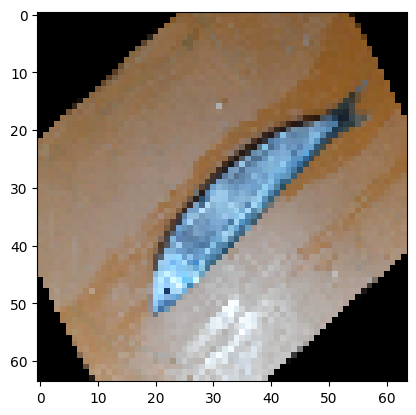

In [19]:
plt.imshow(img[0])

In [21]:
df1.sample(5)

,img
340,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
93,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
309,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
134,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
203,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [22]:
(df['mask'][0])

'data\\Black Sea Sprat GT\\00001.png'

In [23]:
mask = []
for ind in tqdm(range(len(df['mask']))):
    origImage = cv2.imread(df['mask'][ind])
    origImage = cv2.cvtColor(origImage, cv2.COLOR_BGR2GRAY, )
    origImage = cv2.resize(origImage, (64, 64))
    mask.append((origImage>0.5)**2)
df1['mask'] = mask

100%|██████████| 1000/1000 [00:00<00:00, 1821.07it/s]


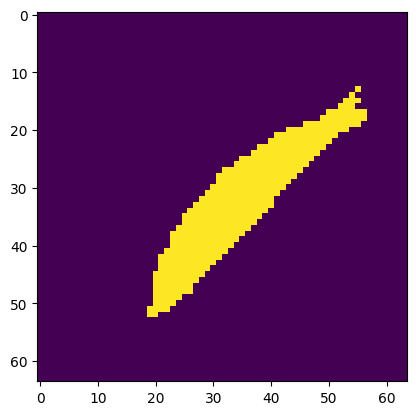

In [24]:
plt.imshow(mask[0])

In [27]:
X_train, X_test = img[:800], img[800:]
y_train, y_test = mask[:800], mask[800:]
type(X_test), type(y_test)

(list, list)

Task 1 (3 points):
    You need to add 3 affine transformations to increase the number of train set

In [37]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None, target_transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        image = Image.fromarray(self.data[index])
        target = Image.fromarray(self.targets[index])

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            target = self.target_transform(target)

        return image, target

    def __len__(self):
        return len(self.data)



# Define your custom transformations
def get_transform(train):
    transform_list = [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]

    if train:
        transform_list = [
            transforms.RandomRotation(30),
            transforms.RandomResizedCrop(64, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
            transforms.RandomHorizontalFlip()
        ] + transform_list

    return transforms.Compose(transform_list)

def get_mask_transform():
    return transforms.Compose([
        transforms.ToTensor()
    ])

In [38]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Assuming MyDataset and get_transform functions are defined elsewhere

# Assuming X_train, y_train, X_test, and y_test are numpy arrays or lists

# Create train and validation datasets
train_dataset = MyDataset(X_train, y_train, get_transform(True), get_mask_transform())
val_dataset = MyDataset(X_test, y_test, get_transform(False), get_mask_transform())


# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)

# Example usage in training loop
for batch in train_loader:
    images, labels = batch
    # Your training code here

# Example usage in validation loop
for batch in val_loader:
    images, labels = batch
    # Your validation code here


In [40]:
import tqdm
for img,target in tqdm.tqdm(val_loader):
    z = 1

100%|██████████| 50/50 [00:00<00:00, 1638.00it/s]


Task 2
1. You task to write fully mirrorr decoder to the neural network and add missing parts to it to the SegNet (5 points)

In [41]:
import torch
import torch.nn as nn

class SegNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SegNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),  # Альтернатива макс анпулинг
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.ConvTranspose2d(64, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Example usage
num_classes = 1
model = SegNet(in_channels=3, out_channels=num_classes).cuda()

In [42]:
def dice_loss(pred, target):
    pred = torch.sigmoid(pred)

    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)

    intersection = torch.sum(pred * target)
    pred_sum = torch.sum(pred * pred)
    target_sum = torch.sum(target * target)

    return 1 - ((2. * intersection + 1e-5) / (pred_sum + target_sum + 1e-5))

In [43]:
criterion = dice_loss
optimizer = SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)

torch.Size([4, 1, 64, 64])


Task 3:
<br> Add visualisation on val (test) set (2 points)

In [81]:
losses = []
vlosses = []
n_epoch = 10
start_time = time.time()

for epoch_num in range(n_epoch):
    loss_ = []
    vloss_ = []
    for i_batch, sampled_batch in enumerate(train_loader):
        image_batch, label_batch = sampled_batch
        #print(image_batch)
        image_batch = image_batch.float()
        image_batch, label_batch = image_batch.cuda(), label_batch.cuda()
        outputs = model(image_batch)
        outputs = torch.squeeze(outputs, 1)
        loss = criterion(outputs, label_batch.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    losses.append(np.mean(loss_,axis = 0))
    print('train epoch ',epoch_num)
    print('-------- train dice ce total', np.mean(loss_,axis = 0))

    model.eval()
    with torch.no_grad():
        for i_batch, sampled_batch in enumerate(val_loader):
            image_batch, label_batch = sampled_batch
            image_batch = image_batch.float()
            image_batch, label_batch = image_batch.cuda(), label_batch.cuda()
            outputs = model(image_batch)
            outputs = torch.squeeze(outputs, 1)
            vloss = criterion(outputs, label_batch.float())
            vloss_.append(vloss.item())

    vlosses.append(np.mean(vloss_))
    print('Validation epoch', epoch_num, '| Loss:', np.mean(vloss_))

end_time = time.time()
print("Total training time: {:.2f} seconds".format(end_time - start_time))

train epoch  0
-------- train dice ce total 0.6296346938610077
Validation epoch 0 | Loss: 0.6005927300453187
train epoch  1
-------- train dice ce total 0.6291605827212333
Validation epoch 1 | Loss: 0.5867951238155364
train epoch  2
-------- train dice ce total 0.6283502343297005
Validation epoch 2 | Loss: 0.5874741518497467
train epoch  3
-------- train dice ce total 0.6276905333995819
Validation epoch 3 | Loss: 0.5936350893974304
train epoch  4
-------- train dice ce total 0.6281486609578133
Validation epoch 4 | Loss: 0.5942026925086975
train epoch  5
-------- train dice ce total 0.6266799512505531
Validation epoch 5 | Loss: 0.588933116197586
train epoch  6
-------- train dice ce total 0.6282048985362053
Validation epoch 6 | Loss: 0.5944628822803497
train epoch  7
-------- train dice ce total 0.6270446765422821
Validation epoch 7 | Loss: 0.5888868856430054
train epoch  8
-------- train dice ce total 0.626631638109684
Validation epoch 8 | Loss: 0.5942702186107636
train epoch  9
------

In [82]:
len(losses), len(vlosses), n_epoch + 1


(10, 10, 11)

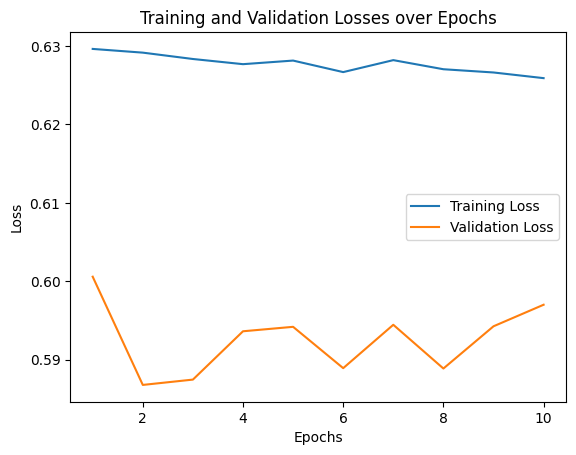

In [83]:
# Create a range of epochs for x-axis
epochs = range(1, len(losses) + 1)

# Plot training and validation losses on the same graph
plt.plot(epochs, losses, label='Training Loss')
plt.plot(epochs, vlosses, label='Validation Loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses over Epochs')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [84]:
model.eval()

SegNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm

In [85]:
d = []

In [86]:
def one_mask(img):
    img = (img-np.min(img))/(np.max(img)-np.min(img))
    img = img.astype(np.float64)
    img = transforms.ToTensor()(img)
    img = img.unsqueeze(0)
    #img = torch.unsqueeze(img, 0)
    img = img.float()
    #print(img)
    img = img.cuda()
    outputs = model(img)
    #outputs = torch.sigmoid(outputs)
    try:
        mask_pred = ((outputs.cpu().detach().numpy() >0.5)**2)
    except:
        mask_pred = np.zeros([128,128])
    return img.cpu().detach().numpy(), mask_pred

In [87]:
X_train[0].shape

(64, 64, 3)

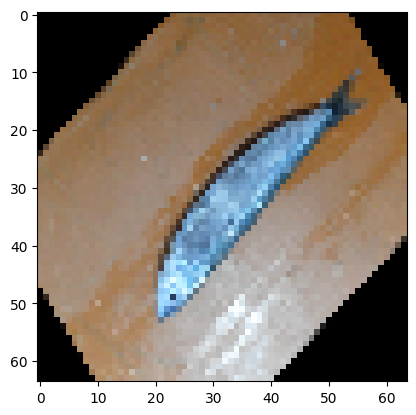

In [88]:
plt.imshow(X_train[10])

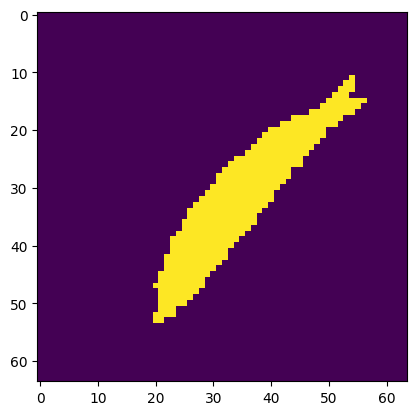

In [89]:
plt.imshow(mask[10])

In [107]:
import numpy as np

def calculate_dice_coefficient(mask_true, mask_pred):
    intersection = np.sum(mask_true * mask_pred)
    union = np.sum(mask_true) + np.sum(mask_pred)

    dice_coefficient = (2.0 * intersection) / (union + 1e-8)  # Добавляем маленькое значение для избежания деления на ноль

    return dice_coefficient

def precision_score(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_pred = np.sum(pred_mask)
    
    if total_pixel_pred == 0: return 0.0
    
    precision = np.mean(intersect/total_pixel_pred)
    return round(precision, 3)

def recall_score(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_truth = np.sum(groundtruth_mask)
    recall = np.mean(intersect/total_pixel_truth)
    return round(recall, 3)

def calculate_iou(mask_true, mask_pred):
    intersection = np.sum(mask_true * mask_pred)
    union = np.sum(mask_true) + np.sum(mask_pred) - intersection

    iou = (intersection + 1e-8) / (union + 1e-8)  # Добавляем маленькое значение для избежания деления на ноль

    return iou
from scipy.spatial.distance import cdist

def hausdorff_distance(mask1, mask2):
    # Получение координат точек в масках
    coords_mask1 = np.transpose(np.nonzero(mask1))
    coords_mask2 = np.transpose(np.nonzero(mask2))

    # Вычисление расстояний между всеми точками в двух масках
    distances_mask1_to_mask2 = cdist(coords_mask1, coords_mask2)
    distances_mask2_to_mask1 = cdist(coords_mask2, coords_mask1)

    # Нахождение максимального расстояния для каждой маски
    max_distance_mask1 = np.max(np.min(distances_mask1_to_mask2, axis=1))
    max_distance_mask2 = np.max(np.min(distances_mask2_to_mask1, axis=1))

    # Вычисление дистанции Хаусдорфа
    hausdorff_distance = max(max_distance_mask1, max_distance_mask2)

    return hausdorff_distance

In [108]:
dice = []
hd = []
prec = []
rec = []
iou = []
for ind,img in tqdm.tqdm(enumerate(X_test)):
    _,mask_pred = one_mask(img)
    mask_true = y_test[ind]
    dice.append(calculate_dice_coefficient(mask_true, mask_pred))
    prec.append(precision_score(mask_true, mask_pred))
    rec.append(recall_score(mask_true, mask_pred))
    iou.append(calculate_iou(mask_true, mask_pred))

200it [00:00, 630.48it/s]


In [109]:

print(np.mean(dice))
print(np.mean(iou))
print(np.mean(prec))
print(np.mean(rec))


0.055848819459884604
0.030416212199318574
0.368435
0.031380000000000005


Open questions: (5 points)
<br> 1. Write the moticaiton and limits of data augmentation
<br> 2. Describe the difference between object detection and image segmentation